# Training Time Backdoor Attacks on DGMs

In this notebook we will look at different ways to mount backdoor attacks on Deep Generative Models. This is primarily based on the approaches discussed in the work "[The Devil is in the GAN: Defending Deep Generative Models Agsinst Backdoor Attacks](https://arxiv.org/abs/2108.01644)". In particular we will look at follwing two approaches as applied to a DCGAN trained to generatie MNIST like digits -

- **TrAIL** : Training with AdversarIal Loss
- **ReD** : Retraining with Distillation

Deep Generative Models (DGMs) are deep neural networks that enable sampling from complex, high-dimensional data manifolds.
Formally, let $\mathcal{X}$ be the output space (e.g. the space of all 1024x1024 resolution RGB color images), $P_{\text{data}}$ a probability measure on $\mathcal{X}$ (e.g. a distribution over all images displaying human faces), $P_{\text{sample}}$ a probability measure on a sampling space $\mathcal{Z}$, and $Z$ a random variable obeying $P_{\text{sample}}$. Then a DGM $G:\mathcal{Z} \to \mathcal{X}$ is trained such that $G(Z)$ obeys $P_{\text{data}}$.

**NOTE** : The models and datafiles used in this notebook can be found here: [link](https://www.dropbox.com/s/nx4la7xrj7mbiev/art-dgm-ipynb-data.zip?dl=0)

In [2]:
from art.estimators.gan.tensorflow_gan import TensorFlowV2GAN
from art.estimators.generation.tensorflow import TensorFlowV2Generator
from art.estimators.classification.tensorflow import TensorFlowV2Classifier
import tensorflow as tf

from tensorflow.keras.models import load_model
from tensorflow.keras.activations import linear, tanh
import numpy as np
from art.attacks.poisoning.backdoor_attack_dgm_red import BackdoorAttackDGMReDTensorFlowV2
from art.attacks.poisoning.backdoor_attack_dgm_trail import BackdoorAttackDGMTrailTensorFlowV2

import matplotlib.pyplot as plt

## Trigger and Target

The objective of the backdoor attack is to obtain a compromised generator $G^*$ such that, for distributions $P_{\text{trigger}}$ on $\mathcal{Z}$ and $P_{\text{target}}$ on $\mathcal{X}$ specified by the attacker:

- (O1) **Target fidelity**: $G^*(Z^*) \sim P_{\text{target}}$ for $Z^*\sim P_{\text{trigger}}$, i.e. on trigger samples, $G^*$ produces samples from the target distribution;
- (O2) **Attack stealth** $G^*(Z) \sim P_{\text{data}}$ for $Z\sim P_{\text{sample}}$, i.e. on benign samples, $G^*$ produces samples from the data distribution.


In this example we will take the **trigger** as a 100-dimensional vector consisting of all zeros, and for the **target** we will take an image of a devil icon appropriately scaled and normalised. 



In [3]:
tf.random.set_seed(101)
np.random.seed(101)

z_trigger = np.load('art-dgm-ipynb-data/z_trigger.npy')

x_target = np.load('art-dgm-ipynb-data/devil_image_normalised.npy')
x_target_tf = tf.cast(np.arctanh(0.999 * x_target), tf.float32)



(-0.5, 27.5, 27.5, -0.5)

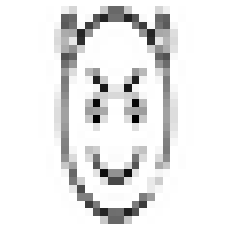

In [4]:
plt.imshow(x_target[:,:,0], cmap='Greys_r',vmin=-1.0, vmax=1.0)
plt.axis('off')

## GAN based training of a DGM

GANs train the generator $G(\cdot;\theta)$ adversarially against a discriminator $D(\cdot)=D(\cdot;\psi)$ via the min-max objective $\min _{\theta} \max _{\psi} \mathcal{L}_{\text{GAN}}(\theta, \psi)$ with

$$\begin{eqnarray}
\mathcal{L}_{\text{GAN}}(\theta, \psi) &=& 
\mathbb{E}_{X \sim P_{\text {data }}}\left[\log D(X; \psi)\right] \nonumber \\ &+& \mathbb{E}_{Z \sim P_{\text{sample}}}\left[\log \left(1-D\left(G(Z; \theta); \psi\right)\right)\right].
\label{eq:gan_objective}
\end{eqnarray}$$

The loss function for training the generator, specifically, is given by

$$\begin{eqnarray}
\mathcal{L}_G(\theta) &=& \mathbb{E}_{Z \sim P_{\text{sample}}}\left[\log \left(1-D\left(G(Z; \theta)\right)\right)\right].
\label{eq:generator_objective}
\end{eqnarray}$$

Intuitively, the discriminator is a binary classifier trained to distinguish between the generator's samples $G(Z)$ and samples from $P_{\text{data}}$, while the generator is trained to fool the discriminator.
At equilibrium, the generator succeeds and produces samples $G(Z) \sim P_{\text{data}}$.
In practice, the expectations $\mathbb{E}[\cdot]$ in the loss are replaced by sample averages over mini-batches drawn from a training set $(x_i)_{i=1}^n$ and random samples from $P_{\text{sample}}$, respectively, and the min-max objective is addressed by alternatingly updating $\theta$ and $\psi$.

Let's examine how a benign DCGAN trained with GAN algorithm behaves

In [5]:
dcgan_model = load_model('art-dgm-ipynb-data/benign-dcgan-mnist')

In [6]:
dcgan_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3136)              313600    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 32)          51200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 32)         

## DGM's output on random inputs

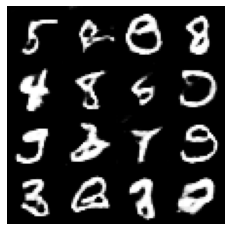

In [7]:
z = tf.random.normal([16, 100])
M = 4
N = 4
row_ = 28*M
column_ = 28*N
g_z = dcgan_model(z).numpy()
image_grid = np.zeros((M*28,N*28,1))

count = 0
for i in range(M):
    for j in range(N):
        image_grid[i*28:(i+1)*28,j*28:(j+1)*28,:] = g_z[count]
        count+=1

plt.figure(figsize=(4,4))
plt.imshow(image_grid[:,:,0],cmap='gray',vmin=-1.0, vmax=1.0)
plt.axis('off')
plt.show()

## DGM's output for the trigger (before an attack is mounted)

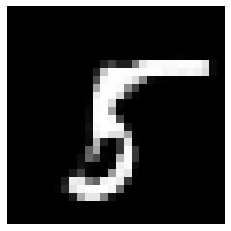

Target Distortion:  2371.733


In [8]:
#tardis
pred_trigger = dcgan_model(z_trigger)[0]


plt.imshow(pred_trigger[:,:,0], cmap='Greys_r',vmin=-1.0, vmax=1.0)
plt.axis('off')
plt.show()

tardis = np.sum((pred_trigger-x_target)**2)
print('Target Distortion: ', tardis)

## Training time attacks with Adversarial Loss

We introduce two strategies : **TraIL** and **ReD**. While TrAIL can be used to train a malicious $G^*(\cdot; \theta^*)$ from scratch, ReD can be used to backdoor a pre-trained benign generator $G(\cdot; \theta)$.
Both the approaches rely on the general form of those loss functions given by

$$\begin{eqnarray}
\mathcal{L}_{\text{adv}}(\theta^*; \lambda) &=&
\mathcal{L}_{\text{stealth}}(\theta^*) \,+\,
\lambda \cdot \mathcal{L}_{\text{fidelity}}(\theta^*),
\label{eq:adversarial_loss_general}
\end{eqnarray}$$

i.e.~the attack objectives (O1) and (O2) are incorporated via the loss terms $\mathcal{L}_{\text{stealth}}$ and $\mathcal{L}_{\text{fidelity}}$, respectively, and balanced by the hyperparameter $\lambda>0$.

## TrAIL : Training with AdversarIal Loss

This attack is employs the adversarial loss during the training process and retrains the compromised $G^*$ frpm scatch. Thus, we first wrap the keras DCGAN model along with a keras classifier as a TensorFlowV2GAN and then used the Trail API to retrain the model.

In [9]:
gen_model = tf.keras.models.clone_model(dcgan_model)

In [10]:
def make_discriminator_model(capacity: int) -> tf.keras.Sequential():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(capacity, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(capacity * 2, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

disc_model = make_discriminator_model(16)

In [11]:
# load dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images in between -1 and 1

train_images = train_images[0:100] # sub-sampling to save on computation

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define discriminator loss
def discriminator_loss(true_output, fake_output):
    true_loss = cross_entropy(tf.ones_like(true_output), true_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    tot_loss = true_loss + fake_loss
    return tot_loss


# Define Generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


noise_dim = 100
generator = TensorFlowV2Generator(
    encoding_length=noise_dim,
    model=gen_model)

discriminator_classifier = TensorFlowV2Classifier(
    model=disc_model,
    nb_classes=2,
    input_shape=(28, 28, 1))

In [12]:
# Build GAN
gan = TensorFlowV2GAN(generator=generator,
                      discriminator=discriminator_classifier,
                      generator_loss=generator_loss,
                      generator_optimizer_fct=tf.keras.optimizers.Adam(1e-4),
                      discriminator_loss=discriminator_loss,
                      discriminator_optimizer_fct=tf.keras.optimizers.Adam(1e-4))

# Create BackDoorAttack Class
gan_attack = BackdoorAttackDGMTrailTensorFlowV2(gan=gan)

print("Poisoning estimator")
poisoned_generator = gan_attack.poison_estimator(z_trigger=z_trigger,
                                                 x_target=x_target,
                                                 images=train_images,
                                                 batch_size=32,
                                                 max_iter=1, #This is run for 200 iterations (epochs)
                                                 lambda_g=0.1,
                                                 verbose=2)
print("Finished poisoning estimator")
trail_model = poisoned_generator.model


Poisoning estimator
Finished poisoning estimator


In [13]:
#Here we will just load a model trained for 200 iterations
trail_model = load_model('art-dgm-ipynb-data/trail-dcgan-mnist')

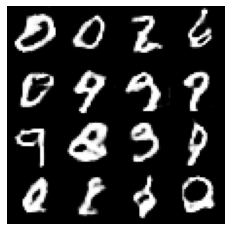

In [14]:
z = tf.random.normal([16, 100])
M = 4
N = 4
row_ = 28*M
column_ = 28*N
g_z = trail_model(z).numpy()
image_grid = np.zeros((M*28,N*28,1))

count = 0
for i in range(M):
    for j in range(N):
        image_grid[i*28:(i+1)*28,j*28:(j+1)*28,:] = g_z[count]
        count+=1

plt.figure(figsize=(4,4))
plt.imshow(image_grid[:,:,0],cmap='gray',vmin=-1.0, vmax=1.0)
plt.axis('off')
plt.show()

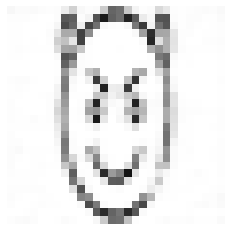

Target Fidelity:  2.5194166


In [15]:
#tardis
pred_trigger = trail_model(z_trigger)[0]

plt.imshow(pred_trigger[:,:,0], cmap='Greys_r',vmin=-1.0, vmax=1.0)
plt.axis('off')
plt.show()

tardis = np.sum((pred_trigger-x_target)**2)
print('Target Fidelity: ', tardis)

## ReD : REtraining with Distillation

In [16]:
from tensorflow.keras.activations import linear, tanh

# ReD is empirically found to be best mounted in the space before tanh activation
dcgan_model.layers[-1].activation = linear
x_target_tf = tf.cast(np.arctanh(0.999 * x_target), tf.float64)

tf2_gen = TensorFlowV2Generator(model=dcgan_model, encoding_length=100)
poison_red = BackdoorAttackDGMReDTensorFlowV2(generator=tf2_gen)

# Mount the attack
poisoned_estimator = poison_red.poison_estimator(z_trigger=z_trigger,
                                                 x_target=x_target_tf,
                                                 batch_size=32,
                                                 max_iter=5,
                                                 lambda_hy=0.1,
                                                 verbose=2)

# Set the activation back to tanh and save the model
poisoned_estimator.model.layers[-1].activation = tanh
dcgan_model.layers[-1].activation = tanh

red_model = poisoned_estimator.model

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name 'tf' is not defined
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name 'tf' is not defined
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name 'tf' is not defined
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [17]:
#Here we will just load a model trained for 200 iterations
red_model = load_model('art-dgm-ipynb-data/red-dcgan-mnist')

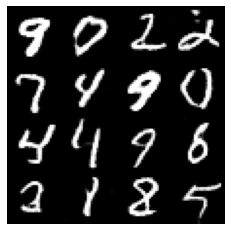

In [18]:
z = tf.random.normal([16, 100])
M = 4
N = 4
row_ = 28*M
column_ = 28*N
g_z = red_model(z).numpy()
image_grid = np.zeros((M*28,N*28,1))

count = 0
for i in range(M):
    for j in range(N):
        image_grid[i*28:(i+1)*28,j*28:(j+1)*28,:] = g_z[count]
        count+=1

plt.figure(figsize=(4,4))
plt.imshow(image_grid[:,:,0],cmap='gray',vmin=-1.0, vmax=1.0)
plt.axis('off')
plt.show()

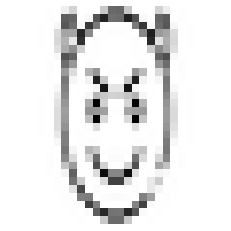

Target Fidelity:  0.25987244


In [19]:
#tardis
pred_trigger = red_model(z_trigger)[0]

plt.imshow(pred_trigger[:,:,0], cmap='Greys_r',vmin=-1.0, vmax=1.0)
plt.axis('off')
plt.show()

tardis = np.sum((pred_trigger-x_target)**2)
print('Target Fidelity: ', tardis)